In [1]:
import os
import time
import json
import random
import copy
from pathlib import Path
try:
    import kagglehub
except ImportError:
    !pip install -q kagglehub
    import kagglehub

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Скачиваем датасет с Kaggle...

In [3]:

path = kagglehub.dataset_download("maysee/mushrooms-classification-common-genuss-images")
print("Path to dataset files:", path)
DATA_DIR = Path(path)

Path to dataset files: /root/.cache/kagglehub/datasets/maysee/mushrooms-classification-common-genuss-images/versions/1


In [4]:
if (DATA_DIR / 'Mushrooms').exists():
    DATA_DIR = DATA_DIR / 'Mushrooms'

DATA_DIR

PosixPath('/root/.cache/kagglehub/datasets/maysee/mushrooms-classification-common-genuss-images/versions/1/Mushrooms')

# Анализируем данные

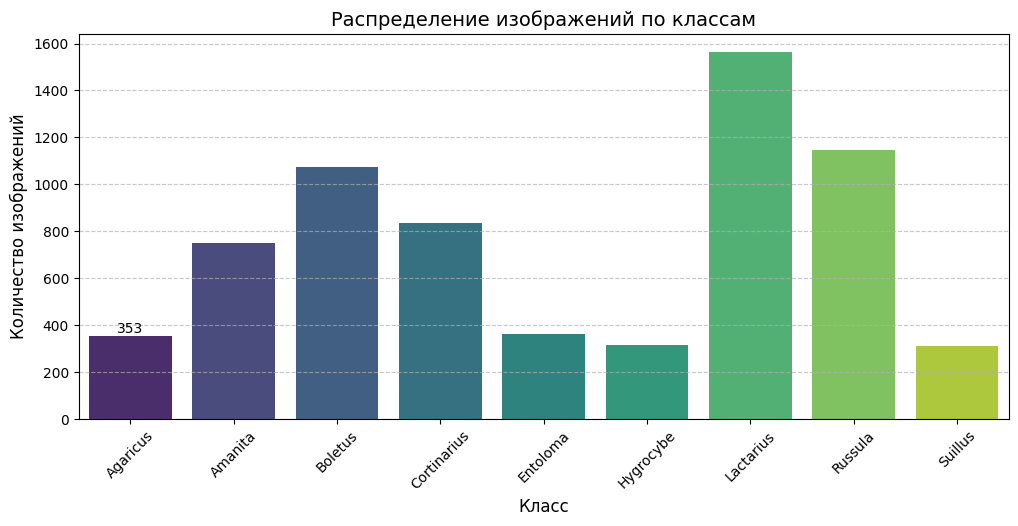

In [5]:
classes = sorted([d.name for d in DATA_DIR.iterdir() if d.is_dir()])
class_counts = {c: len(list((DATA_DIR / c).glob('*'))) for c in classes}

plt.figure(figsize=(12, 5))
barplot = sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), hue=list(class_counts.keys()), legend=False, palette="viridis")
plt.title("Распределение изображений по классам", fontsize=14)
plt.xticks(rotation=45)
plt.bar_label(barplot.containers[0])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel("Класс", fontsize=12)
plt.ylabel("Количество изображений", fontsize=12)
plt.show()

# Переведем классы на русский

In [6]:
translation_map = {
    "Agaricus": "Шампиньон",
    "Amanita": "Мухомор",
    "Boletus": "Белый гриб",
    "Cortinarius": "Паутинник",
    "Entoloma": "Энтолома",
    "Hygrocybe": "Гигроцибе",
    "Lactarius": "Груздь",
    "Russula": "Сыроежка",
    "Suillus": "Масленок"
}

# Примеры того, что видит сеть

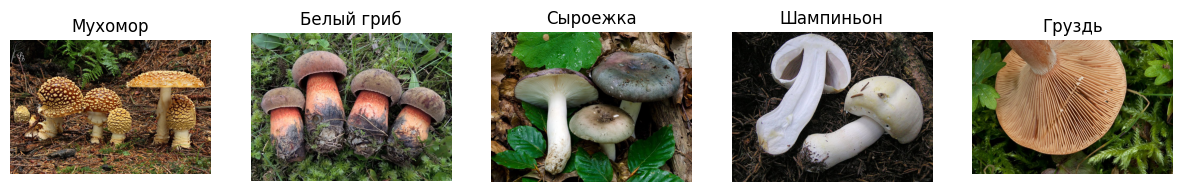

In [7]:
plt.figure(figsize=(15, 8))

for i, c in enumerate(random.sample(classes, min(len(classes), 5))):
    img_path = random.choice(list((DATA_DIR / c).glob('*')))
    img = Image.open(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(translation_map.get(c, c))
    plt.axis("off")
plt.show()

In [8]:
BATCH_SIZE = 32
IMG_SIZE = 224

In [9]:
data_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [10]:
full_dataset = datasets.ImageFolder(DATA_DIR, transform=data_transforms)
class_names = full_dataset.classes

# ВЫЧИСЛЕНИЕ ВЕСОВ КЛАССОВ  

**Формула вычисления веса для класса:**

$$
\text{вес_класса} = \frac{N_{\text{samples}}}{N_{\text{classes}} \times N_{\text{samples_class}}}
$$

где:
 - N_samples — общее количество образцов в датасете,
 - N_classes — количество классов,
 - N_samples_class — количество образцов в текущем классе.


In [11]:

targets = full_dataset.targets
count_array = np.bincount(targets)
total_samples = len(full_dataset)

class_weights = total_samples / (len(class_names) * count_array)
weights_tensor = torch.FloatTensor(class_weights).to(device)

print("\nРассчитанные веса классов:")
for name, weight in zip(class_names, class_weights):
    print(f"{name:15} : {weight:.4f}")


Рассчитанные веса классов:
Agaricus        : 2.1133
Amanita         : 0.9947
Boletus         : 0.6952
Cortinarius     : 0.8923
Entoloma        : 2.0495
Hygrocybe       : 2.3608
Lactarius       : 0.4773
Russula         : 0.6498
Suillus         : 2.3987


# Разбиваем на Train / Val (80/20)

In [12]:

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Создание и обучение модели

In [13]:
model = models.efficientnet_b0(weights='IMAGENET1K_V1')
for param in model.parameters():
    param.requires_grad = False


num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)


criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)


history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
NUM_EPOCHS = 8


from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

print(f"Начинаем обучение на {NUM_EPOCHS} эпох...")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = 100 * correct / total
    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(epoch_acc)

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_epoch_loss = val_loss / len(val_dataset)
    val_epoch_acc = 100 * val_correct / val_total
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.2f}% | "
          f"Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.2f}%")

print("Обучение завершено")

Начинаем обучение на 8 эпох...
Epoch 1/8 | Train Loss: 1.6437 Acc: 45.54% | Val Loss: 1.3281 Acc: 55.40%
Epoch 2/8 | Train Loss: 1.2227 Acc: 58.56% | Val Loss: 1.1728 Acc: 59.42%
Epoch 3/8 | Train Loss: 1.0966 Acc: 60.94% | Val Loss: 1.1437 Acc: 60.83%
Epoch 4/8 | Train Loss: 1.0263 Acc: 62.82% | Val Loss: 1.0814 Acc: 61.43%
Epoch 5/8 | Train Loss: 0.9744 Acc: 63.53% | Val Loss: 1.0610 Acc: 61.80%
Epoch 6/8 | Train Loss: 0.9463 Acc: 65.02% | Val Loss: 1.0258 Acc: 62.40%
Epoch 7/8 | Train Loss: 0.9205 Acc: 65.59% | Val Loss: 1.0367 Acc: 64.11%
Epoch 8/8 | Train Loss: 0.8960 Acc: 66.39% | Val Loss: 1.0129 Acc: 63.96%
Обучение завершено


# Графики обучения

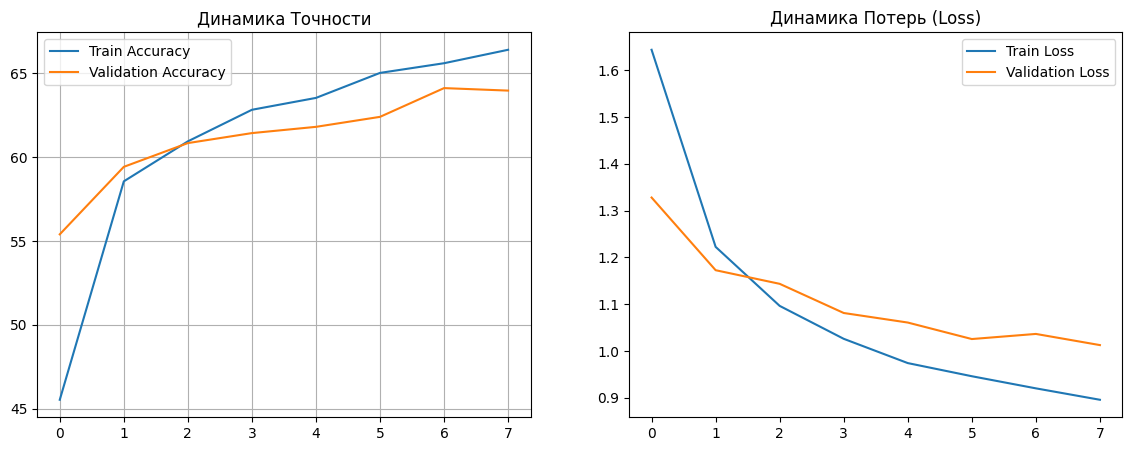

In [14]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Динамика Точности')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Динамика Потерь (Loss)')
plt.legend()

plt.show()

# Матрица Ошибок

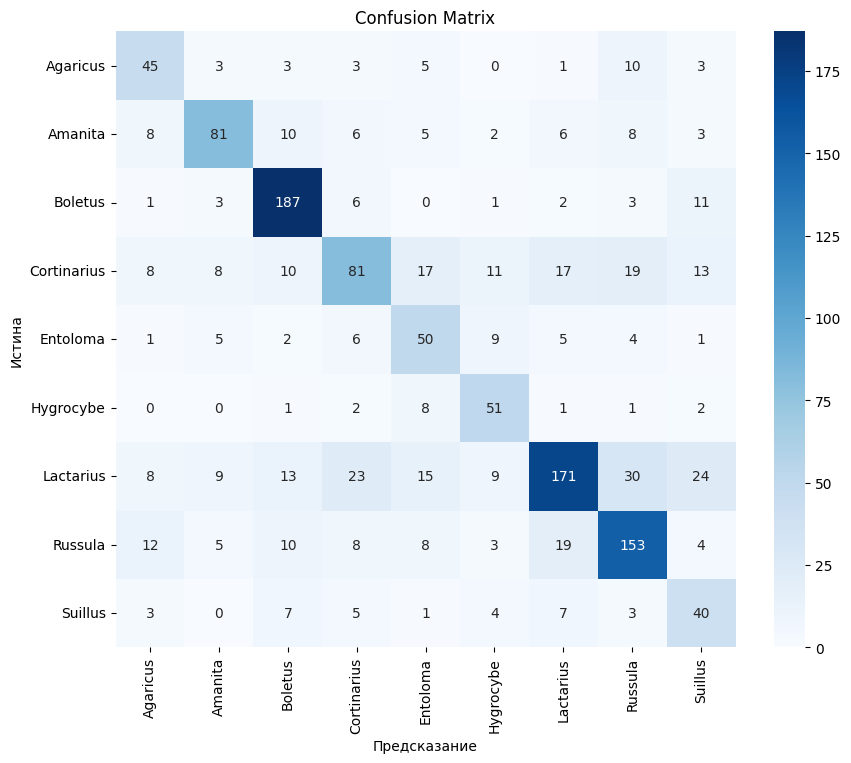

In [15]:
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Истина')
plt.xlabel('Предсказание')
plt.show()

# Classification Report (Precision/Recall Heatmap)

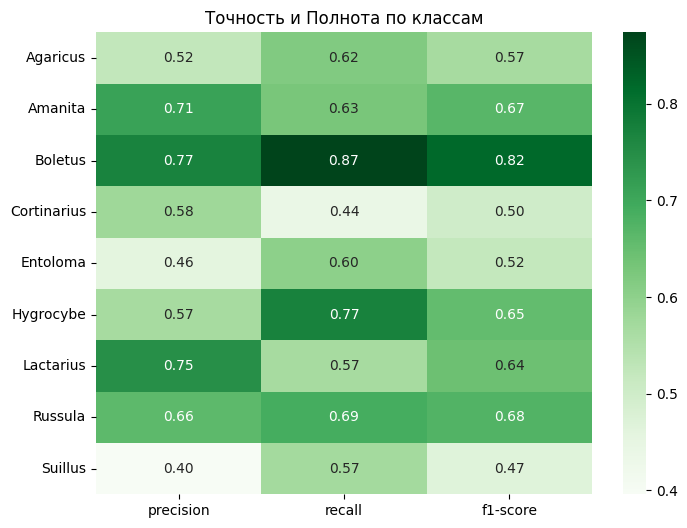

In [16]:


report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose().iloc[:-3, :-1]

plt.figure(figsize=(8, 6))
sns.heatmap(df_report, annot=True, cmap="Greens", fmt=".2f")
plt.title("Точность и Полнота по классам")
plt.show()

# Top-3 Accuracy

In [17]:

def calc_topk(loader, k=3):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, topk = outputs.topk(k, dim=1)
            correct += topk.eq(labels.view(-1, 1).expand_as(topk)).sum().item()
            total += labels.size(0)
    return 100 * correct / total

top3_acc = calc_topk(val_loader, k=3)
print(f"\n Top-1 Acc: {history['val_acc'][-1]:.2f}%")
print(f" Top-3 Acc: {top3_acc:.2f}%")


 Top-1 Acc: 63.96%
 Top-3 Acc: 89.13%


# СОХРАНЕНИЕ НА GOOGLE DRIVE

In [18]:
from google.colab import drive
import os


drive.mount('/content/drive')

save_path = '/content/drive/MyDrive/ТИПиС'
os.makedirs(save_path, exist_ok=True)


torch.save(model.state_dict(), os.path.join(save_path, 'mushroom_model.pth'))
classes_ru = [translation_map.get(c, c) for c in class_names]


with open(os.path.join(save_path, 'config.json'), 'w', encoding='utf-8') as f:
    json.dump(classes_ru, f, ensure_ascii=False)

print(f"\n Файлы сохранены в папку: {save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

 Файлы сохранены в папку: /content/drive/MyDrive/ТИПиС
